# Part 1: Importance Sampling

In this exercise, we will try to evaluate the expectation $E[ I(X_i \in B_{1/2}^{+}) ]$ where $I(.)$ denotes the indicator function, $B_{p}^{+}$ the portion of the unit $p$-norm ball that lies in the nonnegative orthant in $\mathbb{R}^2$ and $X_i \sim Unif(B_{\infty}^{+})$. Since we know the pdf of $X_i$, we only need a clever proposal that will put heavier weight inside the 0.5-norm ball. For this purpose, we choose to sample from two independent exponential distributions of the same rate parameter $\lambda$ s.t. $X_i \sim q(\mathbf{x}) = q_1(x_1)q_2(x_2)$.

Hence we have 
$$
p(\mathbf{x}) = Unif(B_{\infty}^{+}) \\
q(\mathbf{x}) = \lambda^2 \exp(-\lambda (x_1 + x_2))
$$

Since the measure of the set $B_{\infty}^{+}$ is 1, the nominal pdf $p(.)$ is simply 1 for all values in its support. Then the sampler becomes:

$$
E[I(\mathbf{x} \in B_{1/2}^{+})] \approx \dfrac{1}{N} \sum_{i=1}^{N} \dfrac{I(\mathbf{x}^{(i)} \in B_{1/2}^{+})} 
                                                           {\lambda^2 \exp(-\lambda (x_1 + x_2))}
$$

Normally, to calculate the area, we would have to multiply by the area of the support of $p$. However this is unnecessary as we know it to be 1. We finally have to multiply by 4, to account for all 4 quadrants.

Intuitively, instead of sampling uniformly from the unit square and rejecting samples that lie outside the half-norm ball, we put more weight towards the center, and get more samples around the axes. This is really equivalent to rejection sampling on steroids.

For estimating the variance of the estimator (!), we rely on the following formula:

$Var[\hat{\mu_q}] = \dfrac{1}{N} \sum_i \left( 
    \dfrac{I(\mathbf{x} \in B_{1/2})}{\lambda^2 \exp(-\lambda (x_1 + x_2))} - \hat{\mu_q}
    \right)^2
    $

In [ ]:
%matplotlib inline
import numpy as np
import scipy as sp
from matplotlib import pyplot as pl 
import seaborn as sns

To sample a 2-vector of independent exponentials jointly parameterized by rate parameter $\lambda$, we use the inversion trick.

In [85]:
def get_bivar_exp_sample(lbda=.1, n=1000):
    u = np.random.rand(2,n)
    return -np.log(u) / lbda

In [592]:
def get_halfnorm_ball_area(lbda, n=1000):
    x = get_bivar_exp_sample(lbda, n)
    ind = np.linalg.norm(x, .5, axis=0) <= 1
    
    W = 1 / (np.exp(-lbda * np.sum(x, axis=0)) * (lbda**2))
    Wsq = 1 / (np.exp(-2 * lbda * np.sum(x, axis=0)) * (lbda**4))
    mean = np.sum(W[ind])*4 / n
    var = np.square(4*ind.astype(float)*W - mean).sum() / n
    
    return mean,var 

In [602]:
mean, var = get_halfnorm_ball_area(4.)
print "The Expectation of Area: ", mean
print "Estimator Variance: ", var

The Expectation of Area:  0.649405221484
Estimator Variance:  0.582773906375


Luckily, we have an analytical formula for the area of the p-norm ball that we can use to check our calculation. It is:

$m(B_{p}) = \dfrac{\Gamma(1 + \frac{1}{p})^n}{\Gamma(1 + \frac{n}{p})} 2^n$

In [476]:
def analytical_unit_ball_volume(p, n):
    return 2**n * (sp.special.gamma(1. + (1./p))**n) / sp.special.gamma(1. + (n/p))

# analytical_unit_ball_volume(2, 2) # pi!
analytical_unit_ball_volume(.5,2) # close enough!

0.66666666666666663

We experiment to find, empirically, that the best $\lambda$ is around 4.

In [606]:
ls = np.linspace(0.2, 10, 80)

means = []
vararr = []
for i in ls:
    mean, var = get_halfnorm_ball_area(i)
    means.append(mean)
    vararr.append(var)

Minimizing lambda value:  3.79746835443
Minimum Variance:  0.464386832062


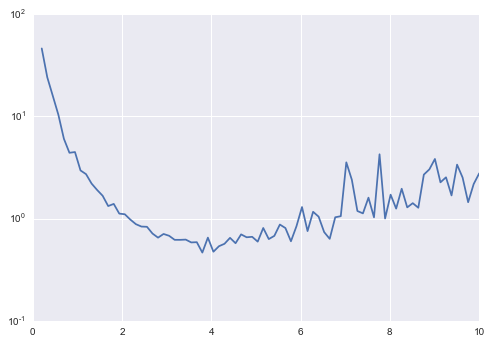

In [607]:
pl.semilogy()
pl.plot(ls, vararr)

print "Minimizing lambda value: ", ls[np.argmin(vararr)]
print "Minimum Variance: ", np.min(vararr)

# Part 2: The Die

We first describe the algebraic relationship in state transitions of the die. Let every state of the die be $n_i$. Then the transition probability for one roll is $p(f_t|n_t) = Uni(A \backslash \{n_t, 7-n_t\})$. We define $A = \{1,2,3,4,5,6\}$. The result is then transformed according to a map $g$:

$$
n_{t+1} = g(n_t, f_t) = 
\begin{cases} 
      n_t & f_t(\mod 4) = 0 \\
      7 -f_t & f_t(\mod 4) = 1 \\
      7 -n_t & f_t(\mod 4) = 2 \\
      f_t & f_t(\mod 4) = 3 \\
   \end{cases}
$$


In [576]:
def g(n, f):
    return [n, 7-f, 7-n, f][f % 4]

A = np.zeros((6,6))
for i in range(1,7):
    D = set(range(1,7)).difference((i, 7-i))
    for x in [g(i, x) for x in D]:
        A[x-1, i-1] += .25 #column-stochastic matrix
print A

[[ 0.25  0.    0.    0.    0.    0.25]
 [ 0.25  0.25  0.25  0.25  0.25  0.25]
 [ 0.25  0.25  0.    0.5   0.25  0.25]
 [ 0.    0.    0.5   0.    0.    0.  ]
 [ 0.    0.25  0.    0.    0.25  0.  ]
 [ 0.25  0.25  0.25  0.25  0.25  0.25]]


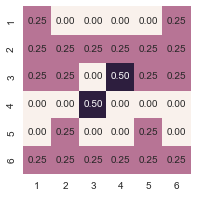

In [581]:
pl.figure(figsize=(3,3))
sns.heatmap(A, annot=True, fmt=".2f", xticklabels=range(1,7), yticklabels=range(1,7), cbar=False)

In [578]:
val, v = sp.linalg.eig(A)
v = v[:,np.isclose(val, 1.0)].ravel()
stat =v/ np.sum(v) # the stationary distribution
print stat

[ 0.08333333  0.25        0.22222222  0.11111111  0.08333333  0.25      ]


The detailed balance condition, we check as follows:

In [579]:
np.allclose(A * stat, (A.T * stat).T)

False

Below we carry out the experiments for items (d) and (e) of the question.

[ 1.  0.  0.  0.  0.  0.]


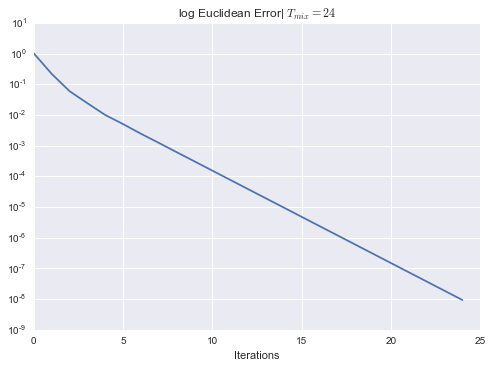

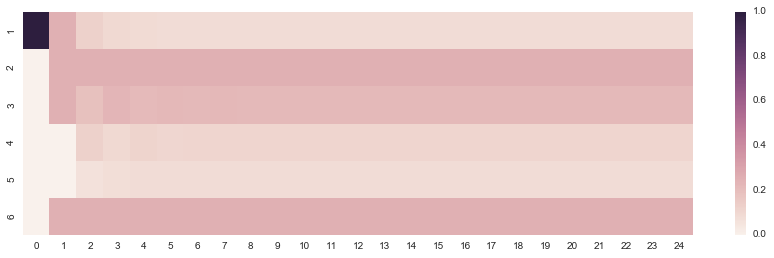

In [13]:
#pi = np.random.multinomial(1, [1/6.]*6, size=1).ravel()
def ket(i, n):
    a = np.zeros(n)
    a[i] = 1
    return a

pi = ket(0,6)

print pi
def run_until_mix(pi, A, tol=1e-8):
    err = [np.linalg.norm(pi - stat)]
    mix = np.matrix(pi).T

    while err[-1] > tol:
        pi = A.dot(pi)
        mix = np.c_[mix, np.matrix(pi).T]
        err.append(np.linalg.norm(pi - stat))
        
    return pi, err, mix

pi,err,mix = run_until_mix(pi, A)

pl.yscale("log")
pl.title("log Euclidean Error" + "| $T_{mix} = %d$" % (len(err)-1))
pl.xlabel("Iterations")
pl.plot(err)
pl.show()

#pl.imshow(mix, interpolation="none")
f = pl.figure(figsize=(15,4))
sns.heatmap(mix, yticklabels=range(1,7))

For the rest of the question. We re-implement the chain without the bells and whistles. We also add the functionality to draw a sample. 

In [17]:
def sample_run(st, A, N=24):
    arr = []
    for i in range(N):
        arr.append(st)
        st = np.random.choice(range(6), p=A.dot(ket(st,6))) # advance the chain one step
    return st, arr

In [24]:
# draw 1000 independent samples and plot
samples = []
arrs = []
for i in range(1000):
    run = sample_run(1, A)
    samples.append(run[0])
    arrs.append(run[1])
    
unique, counts = np.unique(np.array(samples) + 1, return_counts=True)


In [25]:
print unique, counts

[1 2 3 4 5 6] [ 85 260 207 115  80 253]


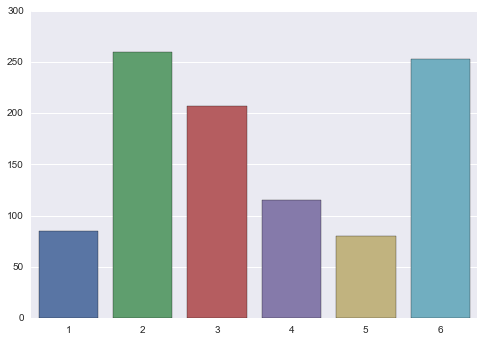

In [38]:
sns.barplot(unique, counts)